# Toronto Dwellings Analysis Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions to create a Panel dashboard.

In [40]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [41]:
# Initialize the Panel Extensions (for Plotly)
import panel as pn
pn.extension("plotly")

In [42]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [43]:
# Import the CSVs to Pandas DataFrames
file_path = Path("./data/toronto_neighbourhoods_census_data.csv")
to_data = pd.read_csv(file_path, index_col="year")

file_path = Path("./data/toronto_neighbourhoods_coordinates.csv")
neighbourhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

### Global available data

In [44]:
# Getting the data from the top 10 expensive neighbourhoods
def top_ten_expensive_neighbourhoods(data):
    
    most_expensive_neighbourhoods = (
        data[['neighbourhood', 'average_house_value']]
        .groupby(['neighbourhood'])
        .mean()
        .sort_values(by='average_house_value', ascending=False)
    )

    return most_expensive_neighbourhoods[:10]


# Calculate the mean number of dwelling types units per year
def mean_dwelling_types_per_year(data):

    dwelling_types = data.drop(columns=data.iloc[:,9:])

    mean_dwelling_types_per_year = (
        dwelling_types
        .groupby([dwelling_types.index, 'neighbourhood'])
        .mean()
        .astype(int)
    )

    return mean_dwelling_types_per_year

# Calculate the average monthly shelter costs for owned and rented dwellings
def average_monthly_shelter_costs(data):

    average_monthly_shelter_costs_per_year = (
        data[['shelter_costs_owned', 'shelter_costs_rented']]
        .groupby([to_data.index])
        .mean()
        .round(2)
    )

    return average_monthly_shelter_costs_per_year


### Panel Visualization Functions

In [65]:
# Define Panel visualization functions
def neighbourhood_map(data):
    """Neighbourhood Map"""
    average_house_value = average_house_value_by_neighbourhood(data)

    scatter_plot = px.scatter_mapbox(
        average_house_value,
        lat='lat',
        lon='lon',
        color='average_house_value',
        size='average_house_value',
        color_continuous_scale='Viridis',
        size_max=11,
        zoom=9.2,
        mapbox_style='carto-positron',
        hover_data={
            'neighbourhood': True,
            'lat': False,
            'lon': False
        }
    )

    return scatter_plot
    

def create_bar_chart(data, title, xlabel, ylabel, color):
    """
    Create a barplot based in the data argument.
    """
    bar_chart = data.figure.bar(
        xlabel=xlabel, 
        ylabel=ylabel, 
        color=color, 
        title=title, 
        figsize=(10,5), 
        rot=65
    )

    # bar_chart.get_legend().remove()

    return bar_chart
    

def create_line_chart(data, title, xlabel, ylabel, color):
    """
    Create a line chart based in the data argument.
    """
    line_chart = data.plot.line(
        xlabel=xlabel, 
        ylabel=ylabel, 
        color=color, 
        title=title, 
        figsize=(15,5)
    )

    line_chart.get_legend().remove()

    return line_chart
    

def average_house_value(data):
    """
    Average house values per year.
    """
    average_house_value_per_year = (
        data[['average_house_value']]
        .groupby([data.index])
        .mean()
        .round(2)
    )

    return average_house_value_per_year
    

def average_house_value_by_neighbourhood(data):
    """
    Average house values by neighbourhood.
    """
    neighbourhood_mean_values = (
        data
        .groupby(['neighbourhood'])
        .mean()
    )

    merged_housing_data = neighbourhood_locations.merge(
        neighbourhood_mean_values, 
        left_on='neighbourhood', 
        right_on='neighbourhood'
    )

    return merged_housing_data
    

def number_dwelling_types(data):
    """
    Number of dwelling types per year
    """
    dwelling_types_per_year = (
        data
        .groupby([data.index])
        .sum()
    )

    dwelling_types_per_year.drop(columns=[
            'average_house_value', 
            'shelter_costs_owned', 
            'shelter_costs_rented'
        ], 
        inplace=True
    )

    return dwelling_types_per_year
    

def average_house_value_snapshot():
    """
    Average house value for all Toronto's neighbourhoods per year.
    """
    average_house_value_snapshot = (
        average_house_value_by_neighbourhood().reset_index()
    )

    average_house_value_snapshot.columns = [
        'Year', 
        'Neighbourhood', 
        'Avg. House Value'
    ]

    return average_house_value_snapshot
    

def top_most_expensive_neighbourhoods(data):
    """
    Top 10 most expensive neighbourhoods.
    """
    top_ten_2001 = data[data['year'] == 2001][:10]
    top_ten_2011 = data[data['year'] == 2011][:10]
    top_ten_2006 = data[data['year'] == 2006][:10]
    top_ten_2016 = data[data['year'] == 2016][:10]

    # Join the dataframes
    top_ten_expensive_neighbourhoods_per_year = pd.concat(
        [top_ten_2001, top_ten_2006, top_ten_2011, top_ten_2016], 
        join='inner', 
        axis='rows'
    )
    

def sunburts_cost_analysis(data):
    """
    Sunburst chart to conduct a costs analysis of most expensive
    neighbourhoods in Toronto per year.
    """
    sunburst_chart = px.sunburst(
        data, 
        path=['year', 'neighbourhood'], 
        values='average_house_value', 
        color='average_house_value', 
        color_continuous_scale='blues',
    )

    return sunburst_chart
    

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

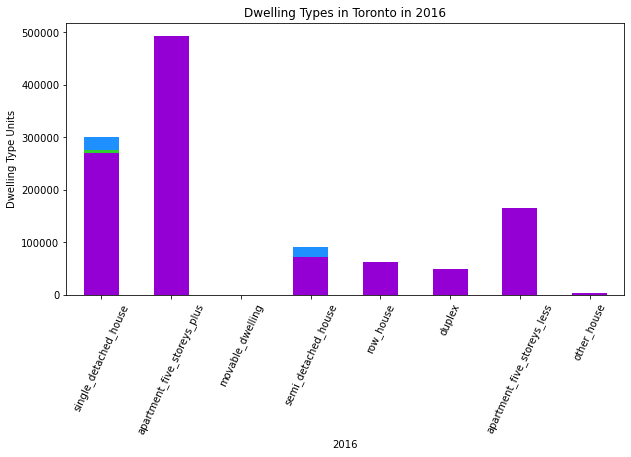

In [66]:
# Create a Title for the Dashboard
dashboard = pn.Column('## Real Estate Analysis of Toronto from 2001 to 2016')


# Define a welcome text
welcome_message = '''
Welcome to Toronto's Real Estate Analysis dashboard. In this dashboard 
you will find historical house values, dwelling types by neghbourhood and 
their associated costs over the years. Navigate through the tabs above to 
see more details on the evolution of Toronto's real estate market."
'''

# Create the Welcome view
scatter_plot = neighbourhood_map(to_data)
welcome_column = pn.Column(
    welcome_message,
    scatter_plot
)

# Create the Yearly Market Analysis view
dwelling_types_per_year = number_dwelling_types(to_data)
bar_chart_2001 = create_bar_chart(
    dwelling_types_per_year.loc[2001], 
    'Dwelling Types in Toronto in 2001', 
    '2001', 
    'Dwelling Type Units', 
    'DodgerBlue'
)
bar_chart_2006 = create_bar_chart(
    dwelling_types_per_year.loc[2006], 
    'Dwelling Types in Toronto in 2006', 
    '2006', 
    'Dwelling Type Units', 
    'DeepPink'
)
bar_chart_2011 = create_bar_chart(
    dwelling_types_per_year.loc[2011], 
    'Dwelling Types in Toronto in 2006', 
    '2011', 
    'Dwelling Type Units', 
    'LimeGreen'
)
bar_chart_2016 = create_bar_chart(
    dwelling_types_per_year.loc[2016], 
    'Dwelling Types in Toronto in 2016', 
    '2016', 
    'Dwelling Type Units', 
    'DarkViolet'
)
yearly_market_analysis_column = pn.Column(
    bar_chart_2001,
    bar_chart_2006,
    bar_chart_2011,
    bar_chart_2016,
)



# Create a tab layout for the dashboard
dashboard = pn.Tabs(
    ("Welcome", welcome_column),
    ("Yearly Market Analysis", yearly_market_analysis_column),
    # ("Shelter Costs vs. House Value", geo_column),
    # ("Neighbourhood Analysis", geo_column),
    # ("Top Expensive Neighbourhoods", geo_column),
)

## Serve the Panel Dashboard

In [67]:
dashboard.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'cac1aea4-307f-4123-83af-3a0dd1f72fcd': {'defs': …

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
    [1] Column
        [0] Str(AxesSubplot)
        [1] Str(AxesSubplot)
        [2] Str(AxesSubplot)
        [3] Str(AxesSubplot)

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [48]:
neighbourhood_map(to_data).show()

In [49]:
# create_bar_chart(data, title, xlabel, ylabel, color)

# # Bar chart for 2001
# create_bar_chart(df_dwelling_units.loc[2001], "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red")

# # Bar chart for 2006
# create_bar_chart(df_dwelling_units.loc[2006], "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue")

# # Bar chart for 2011
# create_bar_chart(df_dwelling_units.loc[2011], "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "orange")

# # Bar chart for 2016
# create_bar_chart(df_dwelling_units.loc[2016], "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta")

In [50]:
# create_line_chart(data, title, xlabel, ylabel, color)

# # Line chart for owned dwellings
# create_line_chart(df_avg_costs["shelter_costs_owned"], "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue")

# # Line chart for rented dwellings
# create_line_chart(df_avg_costs["shelter_costs_rented"], "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "orange")

In [51]:
# average_house_value()

In [52]:
# average_value_by_neighbourhood()

In [53]:
# number_dwelling_types()

In [54]:
# average_house_value_snapshot()

In [55]:
# top_most_expensive_neighbourhoods()

In [56]:
# sunburts_cost_analysis()